In [2]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. Read and clean data

### 1-1. Import **Renewable energy consumption** data manually, and load it. 

Apply the method we saw in the video to **import data** from the **WB**

In [56]:
from pandas_datareader import wb

**Cleanning the Data**

In [58]:
# Renewable energy consumption(% of total final energy consumption)
wb_rec = wb.download(indicator='EG.FEC.RNEW.ZS', country=['DE','DK','IT','LT'], start=2000, end=2019)

wb_rec = wb_rec.rename(columns = {'EG.FEC.RNEW.ZS':'rec'})
wb_rec = wb_rec.reset_index()
wb_rec.sample(5)

,country,year,rec
38,Denmark,2001,11.12
33,Denmark,2006,15.26
34,Denmark,2005,16.12
2,Germany,2017,15.22
65,Lithuania,2014,27.73


In [59]:
wb_rec.year = wb_rec.year.astype(int) # convert year
wb_rec.country = wb_rec.country.astype('string') # convert country to the special pandas string type
wb_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  80 non-null     string 
 1   year     80 non-null     int64  
 2   rec      80 non-null     float64
dtypes: float64(1), int64(1), string(1)
memory usage: 2.0 KB


Check if there are missing values

In [60]:
wb_rec.isna().any() #no missing values, so we're not going to remove columns or rows

country    False
year       False
rec        False
dtype: bool

### 1-1. Import **GDP per capita growth** data manually, and load it. 

In [61]:
# GDP per capita growth (% annual)
wb_gdp = wb.download(indicator='NY.GDP.PCAP.KD.ZG', country=['DE','DK','LT','IT'], start=2000, end=2019)

wb_gdp = wb_gdp.rename(columns = {'NY.GDP.PCAP.KD.ZG':'gdp'})
wb_gdp = wb_gdp.reset_index()
wb_gdp.sample(5)

,country,year,gdp
70,Lithuania,2009,-13.887753
10,Germany,2009,-5.454577
51,Italy,2008,-1.615941
26,Denmark,2013,0.513424
33,Denmark,2006,3.572063


In [62]:
wb_gdp.year = wb_gdp.year.astype(int) # convert year
wb_gdp.country = wb_gdp.country.astype('string') # convert country to the special pandas string type
wb_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  80 non-null     string 
 1   year     80 non-null     int64  
 2   gdp      80 non-null     float64
dtypes: float64(1), int64(1), string(1)
memory usage: 2.0 KB


Check for missing values in the Data Frame

In [63]:
wb_gdp.isna().any() #no missing values, so we're not going to remove columns or rows

country    False
year       False
gdp        False
dtype: bool

## Performing some calculations 

I will like to know which is the year that has the highest consumption in renewable energy:
For that I'll do a **line graph** so I can see the case for each year

But first I'll do the calculations manually

In [84]:
wb_rec.groupby('country')['rec'].max()

country
Denmark      37.52
Germany      17.17
Italy        17.27
Lithuania    33.78
Name: rec, dtype: float64

In [85]:
wb_rec_ = wb_rec.copy()
#here I'm combining the splitting and applying in one step with agg 
wb_rec_max = wb_rec_.groupby('country')['rec'].agg('max')

wb_rec_max.name = 'wb_rec_max'

wb_rec_ = wb_rec_.set_index('country').join(wb_rec_max,how='left')

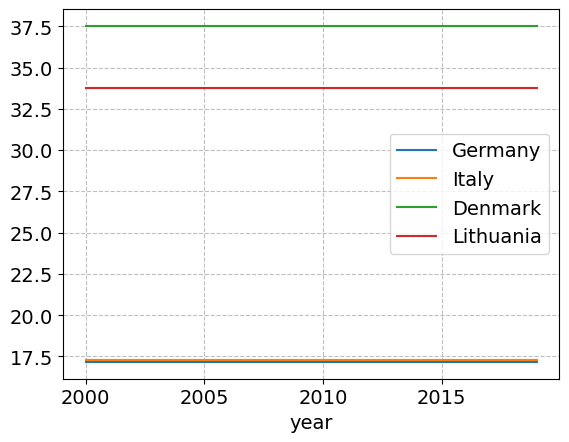

In [86]:
countries = ['Germany','Italy','Denmark','Lithuania']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in countries:
    wb_rec_.xs(i).plot(x='year',y='wb_rec_max',ax=ax,label=i)

In [88]:
wb_gdp.groupby('country')['gdp'].max()

country
Denmark       3.572063
Germany       5.869636
Italy         3.739947
Lithuania    12.435250
Name: gdp, dtype: float64

In [89]:
wb_gdp_ = wb_gdp.copy()
#here I'm combining the splitting and applying in one step with agg 
wb_gdp_max = wb_gdp_.groupby('country')['gdp'].agg('max')

wb_gdp_max.name = 'wb_gdp_max'

wb_gdp_ = wb_gdp_.set_index('country').join(wb_gdp_max,how='left')

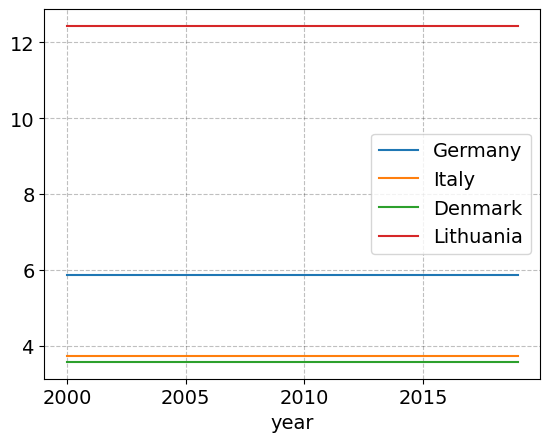

In [91]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in countries:
    wb_gdp_.xs(i).plot(x='year',y='wb_gdp_max',ax=ax,label=i)

## Interactive graph for correlation between both Data Sets

In [100]:
inner_rec = pd.merge( wb_rec, wb_rec_, how='inner', on=['rec','year']) 

inner_gdp = pd.merge( wb_gdp, wb_gdp_, how='inner', on=['gdp','year'])

inner = pd.merge(inner_rec, inner_gdp, how='inner', on=['country','year']) 
inner.head()

,country,year,rec,wb_rec_max,gdp,wb_gdp_max
0,Germany,2019,17.17,17.17,0.828958,5.869636
1,Germany,2018,16.12,17.17,0.678213,5.869636
2,Germany,2017,15.22,17.17,2.297206,5.869636
3,Germany,2016,14.24,17.17,1.408102,5.869636
4,Germany,2015,14.55,17.17,0.617105,5.869636


In [104]:
import ipywidgets as widgets
def plot_e(df, country): 
    I = df['country'] == country
    ax=df.loc[I,:].plot(x='year', y='wb_rec_max', style='o', legend=False)
    ax=df.loc[I,:].plot(x='year', y='wb_gdp_max', style='o', legend=False)

# Let the widget interact with data through plot_func()    
widgets.interact(plot_e, 
df = widgets.fixed(inner),
country = widgets.Dropdown(description='country', 
                                options=inner.country.unique(), 
                                value='Germany')
); 

interactive(children=(Dropdown(description='country', options=('Germany', 'Denmark', 'Italy', 'Lithuania'), va…